### Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [3]:
%%time
p = '../tempNN/'
treated0 = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

control0 = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)


CPU times: user 195 ms, sys: 87.8 ms, total: 283 ms
Wall time: 302 ms


In [4]:
data = [treated0,  control0]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [5]:
%%time
onset = 'Acute-bin'
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 2.25 s, sys: 0 ns, total: 2.25 s
Wall time: 2.25 s


In [6]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 9.08 s, sys: 20.5 ms, total: 9.1 s
Wall time: 9.1 s


In [7]:
%%time
#surv5 = random.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis </br>
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [8]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts



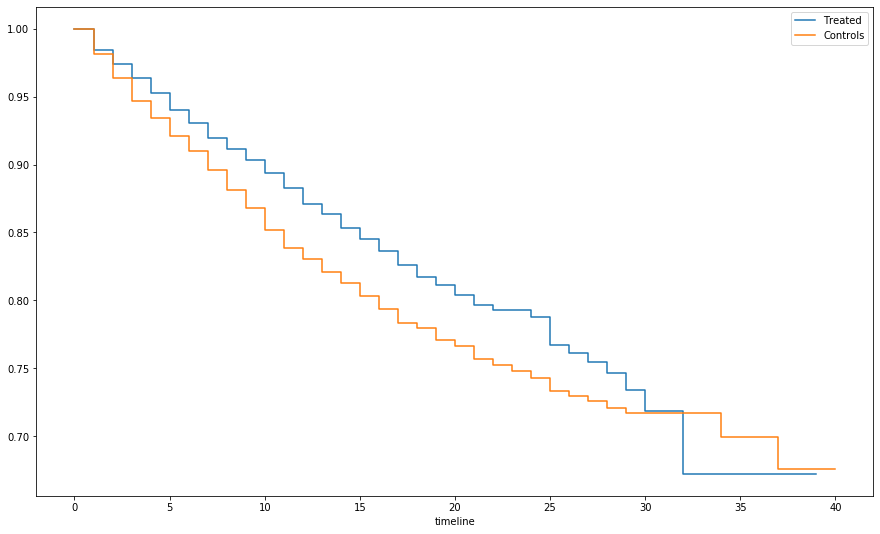

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf = KaplanMeierFitter()

kmf.fit(surv1['T'], event_observed=surv1.E, label="Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)


kmf.fit(surv3['T'], event_observed=surv3.E, label="Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

#ax.set_xlim(0, 25)
#ax.set_ylim(0.94, 1)
fig.show()

In [10]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
           9.31 <0.005      8.78


### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$  
$h(t|x) = h_0(t)f(x)$  
where $h_0$ is the baseline hazard function depending only on time $t$  
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [11]:
from sklearn.preprocessing import MinMaxScaler

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']
surv11 = surv1.loc[:,columns_to_match]
surv31 = surv3.loc[:,columns_to_match]

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)


cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


Iteration 24: norm_delta = 0.03605, step_size = 1.0000, ll = -1435.53620, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 24 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -8189.81212, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.


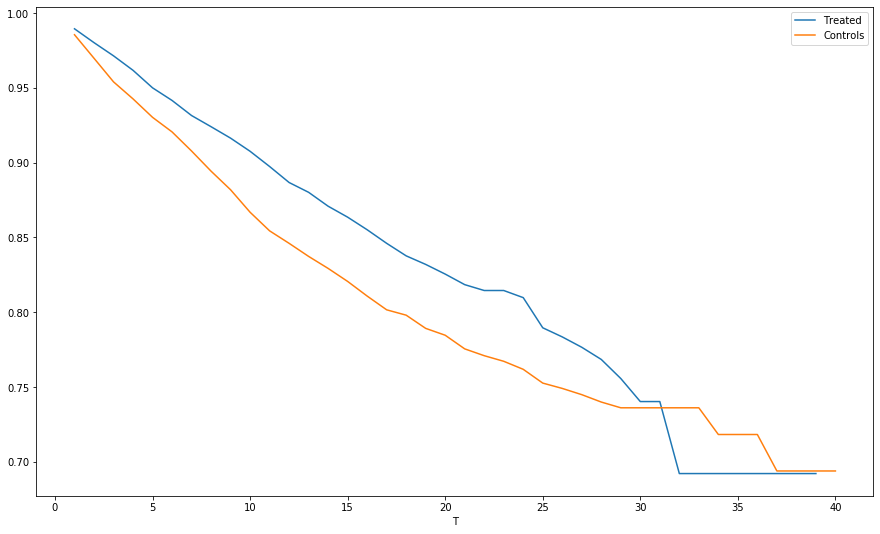

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)
ax.legend(['Treated', 'Controls'])
plt.show()

### Coefficient Plot

### Treated

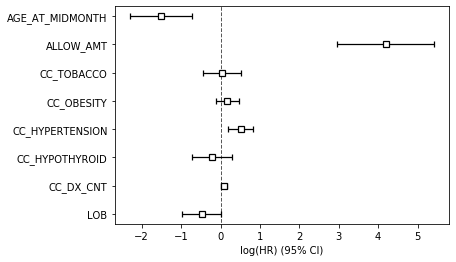

In [13]:
cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB']
cpx1.plot(columns = cols)
plt.show()

### Controls

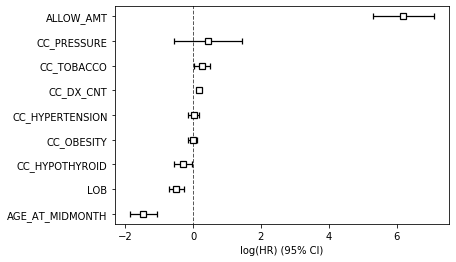

In [14]:
cpx3.plot()
plt.show()

## 1. Matched Controls plus Treated  
<h3><span style="color:red">to study the treatment effect</span></h3>

In [15]:
surv1['Treatment'] = 1

surv3['Treatment'] = 0

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'LOB', 'T', 'E', 'Treatment']

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']


alltogether = pd.concat((surv1,  surv3), axis = 0, ignore_index = True )[columns_to_match]
alltogether[columns_to_normalize] = MinMaxScaler().fit_transform(alltogether[columns_to_normalize].values)

cpxAll = CoxPHFitter().fit(alltogether, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)

Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -10208.48781, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.


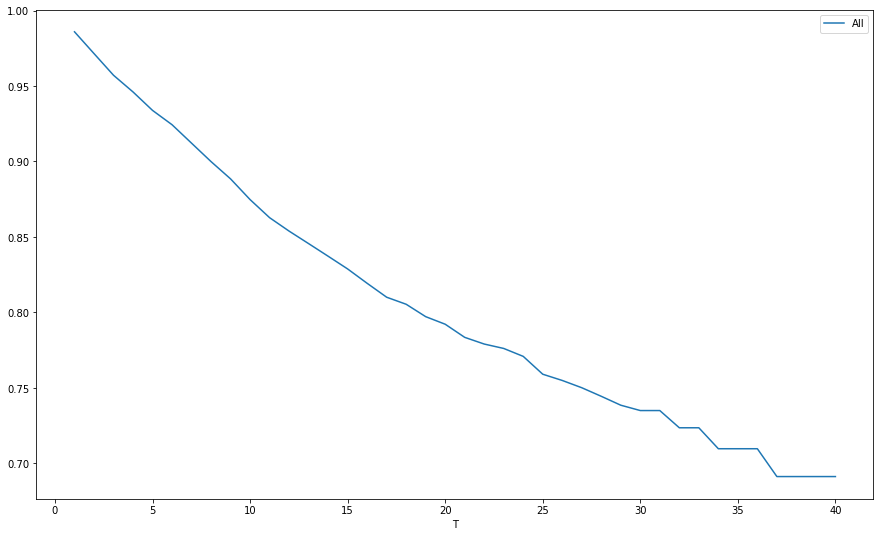

In [16]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpxAll.baseline_survival_.plot(ax = ax)

ax.legend([ 'All'])
plt.show()

### All

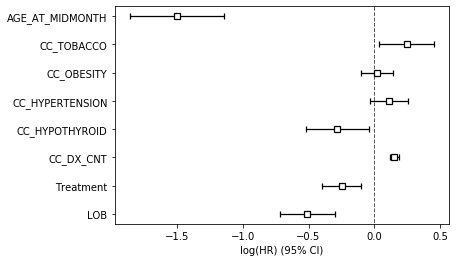

In [17]:
cols = ['AGE_AT_MIDMONTH', 'CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'Treatment', 'LOB']
cpxAll.plot(columns = cols)
plt.show()

### All

In [18]:
cpxAll.params_

AGE_AT_MIDMONTH   -1.500338
ALLOW_AMT          6.429975
CC_TOBACCO         0.245043
CC_PRESSURE        0.312265
CC_OBESITY         0.023216
CC_HYPERTENSION    0.111544
CC_HYPOTHYROID    -0.282125
CC_DX_CNT          0.153347
LOB               -0.508259
Treatment         -0.248620
dtype: float64